In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def relu(x, derivative = False):
    res = x
    if derivative == True:
        return (res > 0)*1
    else:
        return res * (res > 0)

def sigmoid(x, derivative = False):
    res = 1/(1 + np.exp(-x))
    if derivative == True:
        return res * (1 - res)
    else:
        return res
    
def first_moment_update(previous_moment, grad, beta, timestep):
    biased = beta * previous_moment + (1 - beta) * grad
    unbiased = biased / (1 - np.power(beta, timestep))
    return unbiased

def second_moment_update(previous_moment, grad, beta, timestep):
    biased = beta * previous_moment + (1 - beta) * np.square(grad)
    unbiased = biased / (1 - np.power(beta,timestep))
    return unbiased

In [3]:
n_x = 1 # Number of features
m = 1000 # Number of data points
l_1 = 20 # Number of neurons in 1st layer
n_z = 10 # Number of latent variables
alpha = 1e-1 # learning_rate
epochs = 10
batch_size = 128
kl_weight = 5e-3

# Adam parameters
beta_1 = 0.9
beta_2 = 0.999
little_eps = 1e-8

In [4]:
# Testing that everything works before converting to a class
np.random.seed(0)
train_inputs = np.random.randn(m, n_x)
train_inputs = train_inputs.T

learned_params = {}
# learned_params['W_1'] = np.random.randn(l_1, n_x) * np.sqrt(2/n_x) # Kaiming initialization
learned_params['W_1'] = np.random.uniform(low = - np.sqrt(6 / (l_1 + n_x)),
                                          high = np.sqrt(6 / (l_1 + n_x)),
                                          size = (l_1, n_x)) # Xavier
learned_params['b_1'] = np.zeros(shape = (l_1,1))
# learned_params['W_mu'] = np.random.randn(n_z, l_1) * np.sqrt(2/l_1) # Kaiming initialization
learned_params['W_mu'] = np.random.uniform(low = - np.sqrt(6 / (l_1 + n_z)),
                                           high = np.sqrt(6 / (l_1 + n_z)),
                                           size = (n_z, l_1)) # Xavier
learned_params['b_mu'] = np.zeros(shape = (n_z, 1))
# learned_params['W_sigma'] = np.random.randn(n_z, l_1) * np.sqrt(2/l_1) # Kaiming initialization
learned_params['W_sigma'] = np.random.uniform(low = -np.sqrt(6 / (l_1 + n_z)),
                                              high = np.sqrt(6 / (l_1 + n_z)),
                                              size = (n_z, l_1)) # Xavier
learned_params['b_sigma'] = np.zeros(shape = (n_z,1))
# learned_params['W_2'] = np.random.randn(n_x, n_z) * np.sqrt(2/n_z) # Kaiming initialization
learned_params['W_2'] = np.random.uniform(low = -np.sqrt(6 / (n_x + n_z)),
                                          high = np.sqrt(6 / (n_x + n_z)),
                                          size = (n_x, n_z)) # Xavier
learned_params['b_2'] = np.zeros(shape = (n_x, 1))

# Still seems too big, so I'm going to dock everything by 1e-2
# learned_params = {i:j*1e-1 for i, j in learned_params.items()}

learnable_params = learned_params.keys()

first_moments = {i:0 for i in learnable_params}
second_moments = {i:0 for i in learnable_params}
grads = {i:0 for i in learnable_params}

# train_truth = (np.random.sample(size=(n_x,1)) >= 0.5)*1

losses_mse = []
losses_kl = []
losses = []

# Implement mini-batch gradient descent.
batches_per_epoch = (m // batch_size) + 1 - (1 * (isinstance(m / batch_size, int)))
timestep = 1 # Keeps track of how many updates have been done, used by Adam optimizer.

for i in range(epochs):
    for j in range(batches_per_epoch):
        if j == (batches_per_epoch - 1): # Last batch
            batch = train_inputs[:, j* batch_size:]
        else:
            batch = train_inputs[:, j * batch_size: (j+1) * batch_size] # All features, current batch
        
        W_1, b_1, W_mu, b_mu, W_sigma, b_sigma, W_2, b_2 = learned_params.values() # Get the current set of values.
            
        # Forward pass
        z_1 = W_1.dot(batch) + b_1
        a_1 = relu(z_1)

        z_mu = W_mu.dot(a_1) + b_mu
        # There is no activation for mu layer
        z_sigma = W_sigma.dot(a_1) + b_sigma
        
        eps = np.random.randn(n_z, len(batch.T)) # Get the number of rows
        sampled_vector = z_mu + np.multiply(np.exp(z_sigma * 0.5), eps) # Elem-wise multiplication for eps and var.
        # Also treat z_sigma as a log-var instead, bypass the problem with negatives.

        z_2 = W_2.dot(sampled_vector) + b_2
        # Should there be a final activation? 
        # I don't think so - if we're going for MSE loss we're going to compare every single feature vector with the 
        # reconstructed one. So the range of the activation function has to be the whole real line, but most common ones
        # are not that way, like ReLU, tanh, sigmoid.

        # Loss - go with simple L2 loss
        loss_mse = np.mean(np.square(batch - z_2)) # One number
        loss_kl = 0.5*(np.sum(np.exp(z_sigma) + np.square(z_mu) - 1 - z_sigma, axis=0)) # m numbers
        loss = loss_mse + kl_weight * loss_kl # (m,) shape

        losses_mse.append(loss_mse)
        losses_kl.append(np.mean(loss_kl))
        losses.append(loss_mse + np.mean(loss_kl))
        # Warning - KL loss, taking mean is obscuring how some are close to N(0,1) and some are not.

#         if i % 5 == 0:
#             print('The loss from epoch {} batch {} is: '.format(i,j) + str(loss))

        # Backward pass
        # Need one for W_1, b_1, W_mu, b_mu, W_sigma, b_sigma, W_2, b_2
        # This is for MSE loss      
        grad_z_2 = 2* (z_2 - batch) # (n_x, m)
        grad_W_2 = grad_z_2.dot(sampled_vector.T) # (n_z, m)
        grad_b_2 = np.squeeze(np.sum(grad_z_2, keepdims = True))
        grad_s =  W_2.T.dot(grad_z_2) # (n_z, m), gradient of sampled vector
        grad_z_mu = grad_s # (n_z, m)
        grad_z_sigma = np.multiply(grad_s, 0.5 * np.exp(z_sigma * 0.5) * eps)
        grad_W_mu = grad_z_mu.dot(a_1.T)
        grad_b_mu = np.squeeze(np.sum(grad_z_mu, keepdims=True))
        grad_W_sigma = grad_z_sigma.dot(a_1.T)
        grad_b_sigma = np.squeeze(np.sum(grad_z_sigma, keepdims=True))
        grad_a_1 = W_mu.T.dot(grad_z_mu)
        grad_z_1 = np.multiply(grad_a_1, relu(z_1, derivative=True))
        grad_b_1 = np.squeeze(np.sum(grad_z_1, keepdims = True))
        grad_W_1 = grad_z_1.dot(batch.T)

        # This is for KL loss
        grad_z_sigma +=  np.exp(z_sigma) - 1
        grad_z_mu += 2*z_mu # Seriously, wth. There is likely something from KL that can give intuition on this.
        grad_W_sigma += grad_z_sigma.dot(a_1.T)
        grad_b_sigma += np.squeeze(np.sum(grad_z_sigma, keepdims = True))
        grad_W_mu += grad_z_mu.dot(a_1.T)
        grad_b_mu += np.squeeze(np.sum(grad_z_mu, keepdims = True))

        # Store all the gradients (Anyway to write this code cleaner?)
        grads['W_1'] = grad_W_1
        grads['b_1'] = grad_b_1
        grads['W_mu'] = grad_W_mu
        grads['b_mu'] = grad_b_mu
        grads['W_sigma'] = grad_W_sigma
        grads['b_sigma'] = grad_b_sigma
        grads['W_2'] = grad_W_2
        grads['b_2'] = grad_b_2
        
#         for param in learnable_params:
#             learned_params[param] -= alpha * grads[param]
        alpha *= np.sqrt(1-np.power(beta_2,timestep)) / (1 - np.power(beta_1,timestep))
        for param in learnable_params:
            
            first_moments[param] = first_moment_update(previous_moment = first_moments[param], 
                                                       grad = grads[param],
                                                       beta = beta_1,
                                                       timestep = timestep)
            second_moments[param] = second_moment_update(previous_moment = second_moments[param],
                                                         grad = grads[param],
                                                         beta = beta_2,
                                                         timestep = timestep)
            
            learned_params[param] -= alpha * np.divide(first_moments[param],(np.sqrt(second_moments[param]) + little_eps))
    timestep += 1

In [5]:
grads

{'W_1': array([[ -0.41306547],
        [ -5.01006028],
        [ -9.12153797],
        [ -2.03856464],
        [ -1.76596877],
        [-11.37222543],
        [  6.96434058],
        [  4.5475901 ],
        [  6.19198112],
        [  1.74285131],
        [ -7.81971904],
        [-11.54648111],
        [ 13.08714803],
        [  0.36481548],
        [  5.16791527],
        [ -2.87265366],
        [  9.3020681 ],
        [ -6.04877633],
        [  3.43797718],
        [  7.20414915]]),
 'b_1': array(-45.27807821),
 'W_mu': array([[ -7.39593726,  -6.06781515, -10.36899896, -10.80527944,
          -6.28659545, -12.97765906,  -2.48371388,   2.10631466,
           2.19295093,   0.69510648,  -8.96569641,  -9.96997245,
         -10.66552166,   1.75350207,   2.07805465, -11.08461399,
           1.08727503,  -2.67727172, -11.17440462,   0.72022076],
        [ 21.51521707,  17.67330783,  30.15438234,  31.4221324 ,
          18.30580185,  37.7852375 ,   7.41413429,  -6.58998315,
          -6.88964

In [6]:
for k in grads:
    print(k, '----->', np.max(np.abs(grads[k])))
    
# Hey, the weight matrices have gone insane!

W_1 -----> 13.087148027966945
b_1 -----> 45.27807820877068
W_mu -----> 74.09088485773077
b_mu -----> 125.09673332841398
W_sigma -----> 46.67153218919038
b_sigma -----> 258.91943505835343
W_2 -----> 118.51797122310131
b_2 -----> 7.018865839399861


In [7]:
for l in learned_params:
    print(l, '----->', np.max(np.abs(grads[l])))

W_1 -----> 13.087148027966945
b_1 -----> 45.27807820877068
W_mu -----> 74.09088485773077
b_mu -----> 125.09673332841398
W_sigma -----> 46.67153218919038
b_sigma -----> 258.91943505835343
W_2 -----> 118.51797122310131
b_2 -----> 7.018865839399861


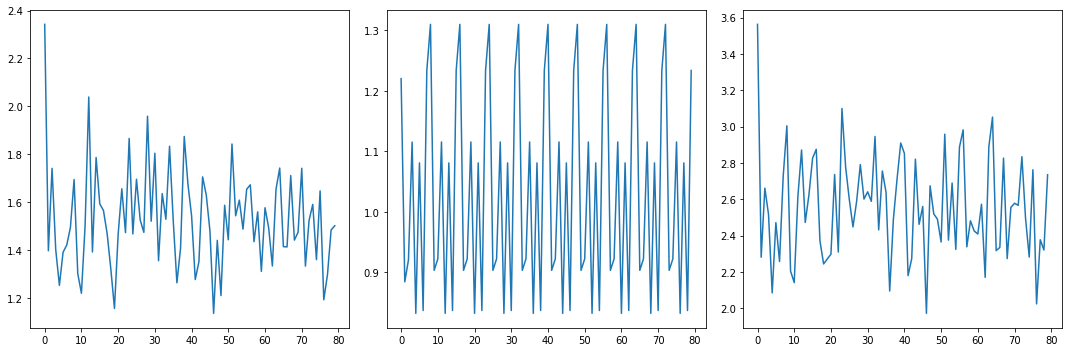

In [8]:
# Plot of losses
plt.figure(figsize = (15,5))
plt.subplot(131)
plt.plot(losses_mse)
# plt.title('Base_implementation_MSE_loss, alpha = {:.3e}'.format(alpha))

plt.subplot(132)
plt.plot(losses_kl)
# plt.title('Base_implementation_KL_loss, alpha = {:.3e}'.format(alpha))

plt.subplot(133)
plt.plot(losses)
# plt.title('Base_implementation_total_loss, alpha = {:.3e}'.format(alpha))
plt.tight_layout()

But is this correct? Any way to visualize a VAE?

Learning rate seems to be insanely important. At small dataset sizes 1e-2 was already good enough. At n_x = 10, m = 1000 then learning rate needed to be 1e-6? Not robust and seems to be heavy contributor to NaN explosions. Phew. Maybe BN can solve this.

This seems to be a problem already because while we can 'experiment' on a low dimension or small batch size, the learning rate may not do so well on the whole dataset. Either implement batch, or an early break when running the code proper.

In [9]:
# Create a bunch of 'sampled vectors' that in reality came out from nowhere and put them through the decoder.
np.random.seed(0)
test_inputs = np.random.randn(n_x, 100) # 100 samples which are 'normal'
test_inputs_anomaly = np.random.randn(n_x, 100) # 100 samples which are anomalous
test_inputs_anomaly = 0.5 + test_inputs_anomaly # Actually have mean 1 and var 1.

def send_through_the_network(inputs):
    W_1, b_1, W_mu, b_mu, W_sigma, b_sigma, W_2, b_2 = learned_params.values()
    z_1_test = W_1.dot(inputs) + b_1
    a_1_test = relu(z_1_test)
    z_mu_test = W_mu.dot(a_1_test) + b_mu
    z_sigma_test = W_sigma.dot(a_1_test) + b_sigma
    test_sampled_eps = np.random.normal(size = z_sigma_test.shape)
    
    # Reparameterization trick
    sampled_vector_test = z_mu_test + np.multiply(test_sampled_eps, np.exp(.5 * z_sigma_test))
    
    # Reconstruct the input
    z_2_test = W_2.dot(sampled_vector_test) + b_2
    
    # Find the reconstruction loss of the decoded test vectors
    rcloss = np.mean(0.5*np.square(z_2_test - test_inputs))
    return rcloss 

print('This is the average loss from 100 points of "normal" data points: ' + str(send_through_the_network(test_inputs)))
print('This is the average loss from 100 points of "anomalous" data points: ' + str(send_through_the_network(test_inputs_anomaly)))

This is the average loss from 100 points of "normal" data points: 0.6322797041177349
This is the average loss from 100 points of "anomalous" data points: 1.6897440319608854


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


IndexError: index 1 is out of bounds for axis 0 with size 1

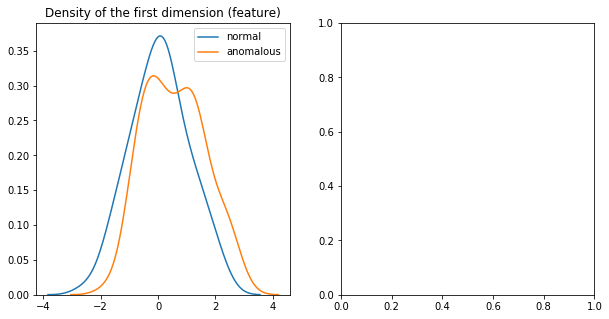

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (10,5))
plt.subplot(121)
sns.kdeplot(test_inputs[0,:], label = 'normal')
sns.kdeplot(test_inputs_anomaly[0,:], label = 'anomalous')
plt.title('Density of the first dimension (feature)')

plt.subplot(122)
sns.kdeplot(test_inputs[1,:], label = 'normal')
sns.kdeplot(test_inputs_anomaly[1,:], label = 'anomalous')
plt.title('Density of the second dimension (feature)')


I think there doesn't seem to be a probabilistic interpretation in this regard, because the output is real-valued. There is no guarantee whatsoever that we will end up with a probability? Can't use sigmoid either. But if that's the case, what is the probabilistic foundation of what we have just done?

I think a better way to see if the network is doing what it should is to produce data points that are certainly anomalous. Then shunt everything through the network, compute reconstruction 'probability' (which is MSE here) and see if it works or not. (Intuition - trivially it should work?)

See how the reconstruction loss changes when we change:
1. The number of neurons in the first layer
2. The number of latent variables
3. The number of features we have? I think 2. is a proxy for this already.